In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import random
import gym
from stable_baselines3 import PPO
from gym import spaces
import math
import matplotlib
import matplotlib.pyplot as plt

# Preliminarys
- Utils

In [9]:
# Utils
def check_or_make(mdir):
    if not (os.path.exists(mdir)):
        os.mkdir(mdir)

CLEAN = False
GRID_WIDTH = 6 # x
GRID_HEIGHT = 6 # y
OBJECT_NUM = 2 # empty = 0; wall = 1 # agent = 2; goal = 3
ACTION_SPACE_DIM = 5 # stay = 0; up = 1; down = 2; left = 3; right = 4
DENSITY = 0.01

EPSILON_NOISE = 0.5

# M
PARA_SIZE = GRID_HEIGHT*GRID_WIDTH//2
# omega's range
OMEGA_RANGE = 5 # (-5, 5)

ITER_NUM = 500
BATCH_SIZE = 64
DEMO_EPISODE = 10

SAVE_DURATION = 100


def direction2action(delta_x, delta_y):
    if (delta_x == 0):
        if (delta_y == 1):
            return 2
        elif (delta_y == 0):
            return 0
        elif (delta_y == -1):
            return 1
    elif (delta_x == 1 and delta_y == 0):
        return 4
    elif (delta_x == -1 and delta_y == 0):
        return 3
    raise Exception("Unknown direction")

def action2direction(action):
    a2d = [(0,0), (0, -1), (0, 1), (-1, 0), (1, 0)]
    return a2d[action]

def point_distance(p1, p2):
    l1 = lambda x,y: abs(x[0]-y[0]) + abs(x[1]-y[1])
    l1 = l1(p1, p2)
    l2 = np.linalg.norm(np.array(p1)-np.array(p2), ord=2)
    return l1

target_task = np.array([
    [2, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 0, 0, 1, 1, 3]
])

cur_dir = os.path.abspath(os.path.curdir)
#GridNet parameters
grid_para_dir = os.path.join(cur_dir, "grid_para")
check_or_make(grid_para_dir)

#IL agent parameters
IL_agent_dir = os.path.join(cur_dir, "IL_agent")
check_or_make(IL_agent_dir)

#Static GridNet parameters
static_grid_para_dir = os.path.join(cur_dir, "static_grid_para")
check_or_make(static_grid_para_dir)

#Pic drawing data
pic_drawing_data_dir = os.path.join(cur_dir, "pic_drawing_data")
check_or_make(pic_drawing_data_dir)

# Bayesian && MiniGridEnv

In [10]:
# DFS Agent
class DFS():        
    def dfs_search(self, obs):
        """
        Given a observation (numpy), return whether solvable or not, and history
        """
        mobs = None
        visited = obs.copy()
        history = []
        
        stack = []
        stack.append((0,0,0))
        
        while(len(stack) > 0):
            cur_x, cur_y, action = stack[-1]
            
            if (visited[cur_y][cur_x] == 1):
                continue
            
            if (len(history) == 0):
                mobs = obs.copy()
                history.append((mobs, action))
            else:
                mobs = history[-1][0].copy() 
                t_action = history[-1][1]
                # set for current trans
                mobs[cur_y - action2direction(action)[1] - action2direction(t_action)[1]][cur_x - action2direction(action)[0] - action2direction(t_action)[0]] = 0
                mobs[cur_y - action2direction(action)[1]][cur_x - action2direction(action)[0]] = 2
                history.append((mobs, action))
           
            
            if (visited[cur_y][cur_x] == 0):
                visited[cur_y][cur_x] = 1
            if (visited[cur_y][cur_x] == 3):
                # finish
                return history[1:], True
                
            neibs = self.get_neighbour(cur_x, cur_y, visited)
            while (len(neibs) == 0):
                stack.pop()
                history.pop()
                if (len(stack) == 0):
                    return history, False
                cur_x, cur_y, action = stack[-1]
                neibs = self.get_neighbour(cur_x, cur_y, visited)
            stack.append(neibs[0])
        return history, False
           
        
    def get_neighbour(self, x, y, obs):
        h, w = obs.shape
        delta_x = [0, 0, -1, 1]
        delta_y = [-1, 1, 0, 0]
        neibs = []
        
        _pos = [i for i in range(len(delta_x))]
        random.shuffle(_pos)
        for i in _pos:
            new_x = x + delta_x[i]
            new_y = y + delta_y[i]
            if (0<= new_x < w and 0 <= new_y < h and (obs[new_y][new_x] == 0 or obs[new_y][new_x] == 3)):
                neibs.append((new_x, new_y, direction2action(delta_x[i], delta_y[i])))
        return neibs

In [12]:
class BFS():
    def solve(self, maze):
        """
        param: maze: numpy.matrix
        return: history: [numpy.matrix, action]
        return: solvable: boolean
        """
        
        # reset param
        self._reset(maze)
        
        self.search_maze = maze.copy()
        self.visited = maze.copy()
        self.visited[np.where(self.visited==3)] = 0
        self.visited[np.where(self.visited==2)] = 0
        
        search = []
        history = []
        
        # start BFS
        search.append((0,0))
        self.visited[0,0] = 1
        
        while(len(search) > 0):
            x,y = search[0]
            search = search[1:]
            
            if (self.search_maze[y,x] == 3):
                self.search_maze[np.where(self.search_maze==2)] = 0
                hx, hy = x, y
                while True:
                    if (hx == 0 and hy == 0):
                        break
                    thisx, thisy = self.parent[hy, hx]
                    action = direction2action(hx-thisx, hy-thisy)
                    if (self.search_maze[hy, hx] == 2):
                        self.search_maze[hy, hx] = 0
                    self.search_maze[thisy, thisx] = 2
                    hx, hy = thisx, thisy
                    history.append((self.search_maze.copy(), action))
                break
            neibs = self._get_neighbour((x,y))
            for n in neibs:
                nx, ny = n
                self.visited[ny, nx] = 1
                self.parent[ny, nx] = (x,y)
                search.append(n)
        
        history.reverse()
        solvable = True
        if len(history) == 0:
            solvable = False
        return history, solvable    
            
        
    def _get_neighbour(self, pos):
        h, w = self.search_maze.shape
        x,y = pos
        delta_x = [0, 0, -1, 1]
        delta_y = [-1, 1, 0, 0]
        neibs = []
        
        for i in range(4):
            new_x = x + delta_x[i]
            new_y = y + delta_y[i]
            if (0<= new_x < w and 0 <= new_y < h and self.visited[new_y][new_x] == 0):
                neibs.append((new_x, new_y))
        return neibs
        
        
    def _reset(self, maze):
        self.parent = np.array([[(-1,-1) for i in range(6)] for i in range(6)])
        self.pos = (0,0)
        self.h, self.w = maze.shape


In [13]:
class GridNet(nn.Module):
    def __init__(self):
        super(GridNet, self).__init__()
        self.fc1 = nn.Linear(PARA_SIZE, GRID_WIDTH*GRID_HEIGHT)
        self.fc2 = nn.Linear(GRID_WIDTH*GRID_HEIGHT, (GRID_WIDTH*GRID_HEIGHT+1)*OBJECT_NUM)
        self.fc3 = nn.LeakyReLU()
        self.fc4 = nn.Softmax(dim=1)
    def forward(self, x):
        with torch.no_grad():
            x = self.fc1(x)
            x = self.fc2(x).view(GRID_WIDTH*GRID_HEIGHT+1, -1)
            x = self.fc3(x)
            x = self.fc4(x)
            z = x[GRID_WIDTH*GRID_HEIGHT]
            x = x[:GRID_WIDTH*GRID_HEIGHT]
            x[:, 0] += DENSITY
            x = x.argmax(dim=1).view(GRID_HEIGHT, GRID_WIDTH)
            return x, z
    def generate_grid(self, _input):
        """
        Generate net with fixed start / end position.
        """
        grid, goal = self.forward(_input)
        grid[0,0] = 2
        goal_x, goal_y = int(goal.numpy()[0]*GRID_WIDTH), int(goal.numpy()[1]*GRID_HEIGHT)
        grid[goal_y, goal_x] = 3
        return grid.numpy(), (goal_x, goal_y)

    
class MiniGridEnv(gym.Env):
    """
    Parameterized MiniGrid Env
    """
    
    def __init__(self, para=torch.rand(PARA_SIZE)):
        super(MiniGridEnv, self).__init__()
        
        # action space
        self.action_space = spaces.Discrete(ACTION_SPACE_DIM)
        # observation space
        self.observation_space = spaces.Box(low=0, high=3, shape=(GRID_HEIGHT, GRID_WIDTH)\
                                           ,dtype=np.uint8)
        
        # maximun steps
        self.max_steps = GRID_HEIGHT*GRID_WIDTH
        
        self.net = GridNet()
        
        # Load mapping M
        self.load_grid_net()
        
        # Para for this env
        self.para = para
        self.grid, self.goal_pos = self.generate_grid()
        self.h, self.w = self.grid.shape
        
        # need reset each time
        self.dis2goal = point_distance((0,0), self.goal_pos)
        self.pos = (0,0)
        self.step_count = 0
    
    def load_grid_net(self, path=None):
        if (path == None):
            path = grid_para_dir

        if os.path.exists(path + "/grid_para.pkl"):
            self.net.load_state_dict(torch.load(path + "/grid_para.pkl"))
        else:
            raise Exception("grid_para.pkl DOES NOT EXISTS IN {}".format(path))
            
    def save_grid_net(self, path=None):
        if (path == None):
            path = grid_para_dir
        try:
            torch.save(self.net.state_dict(), path + "/grid_para.pkl")
        except:
            raise Exception("CANNOT SAVE IN {}".format(path))
    
    def generate_grid(self, para=None):
        if (para==None):
            para = self.para
        noise = torch.randn(PARA_SIZE).numpy()
        noise = EPSILON_NOISE * np.linalg.norm(para, ord=2)  * noise / np.linalg.norm(noise, ord=2)
        noise = torch.from_numpy(noise)
        para = noise
#         print(para)
#         print("Here", self.net.generate_grid(para))
        return self.net.generate_grid(para)
    
    def generate_grid_no_noise(self, para):
        self.para = para
        return self.net.generate_grid(para)
            
        
    def step(self, action):
        x,y = self.pos
        x += action2direction(action)[0]
        y += action2direction(action)[1]
        
        reward = 0
        done = False
        info = {}
        
        if (0 <= x < self.w and 0 <= y < self.h):
            if (self.grid[y][x] == 3):
                reward += 5
                done = True
                info = {"success": True}
            elif (self.grid[y][x] == 0):
                self.grid[self.pos[1]][self.pos[0]] = 0
                self.grid[y][x] = 2
                self.pos = (x,y)
                
                cur_dis2goal = point_distance((x,y), self.goal_pos)
#                 print("cur_dis is {}".format(cur_dis2goal))
                if (cur_dis2goal < self.dis2goal):
                    reward += (self.dis2goal - cur_dis2goal)*1.5
                    self.dis2goal = cur_dis2goal
        else:
            reward -= 1
        reward -= 1
        
        self.step_count += 1
        if (self.step_count > self.max_steps):
            done = True
        
        return self.grid, reward, done, info
    
    def reset(self, **args):
        if (len(args) > 0):
            self.grid = args["grid"]
            self.goal_pos = args["goal_pos"]
        else:
            self.grid, self.goal_pos = self.generate_grid()
        self.h, self.w = self.grid.shape
        
        # need reset each time
        self.dis2goal = point_distance((0,0), self.goal_pos)
        self.pos = (0,0)
        self.step_count = 0
        return self.grid
    
    def render(self, mode='human', close=False):
        return False
    
class SparseRewardMiniGridEnv(MiniGridEnv):
    def step(self, action):
        x,y = self.pos
        x += action2direction(action)[0]
        y += action2direction(action)[1]
        info = {}
        reward = 0
        done = False
        if (0 <= x < self.w and 0 <= y < self.h):
            if (self.grid[y][x] == 3):
                reward = 1
                done = True
                info = {"success": True}
            elif (self.grid[y][x] == 0):
                self.grid[self.pos[1]][self.pos[0]] = 0
                self.grid[y][x] = 2
                self.pos = (x,y)
        self.step_count += 1
        if (self.step_count > self.max_steps):
            done = True     
        return self.grid, reward, done, info


tmpt_env = MiniGridEnv()
fixed_grid = []
for i in range(10):
    fixed_grid.append(tmpt_env.reset())
    
class FixMiniGridEnv(MiniGridEnv):
    def generate_grid(self, para=None):
        grid = random.sample(fixed_grid, 1)[0]
#         print(grid)
        goal_pos = np.where(grid==3)
#         print(goal_pos)
        goal_pos = (goal_pos[1][0], goal_pos[0][0])
        return grid, goal_pos

class RandomMiniGridEnv(MiniGridEnv):
    def reset(self, **args):
        self.grid, self.goal_pos = self.generate_grid(torch.randn(PARA_SIZE))
        self.h, self.w = self.grid.shape
        # need reset each time
        self.dis2goal = point_distance((0,0), self.goal_pos)
        self.pos = (0,0)
        self.step_count = 0
        return self.grid

In [14]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

class Bayesian():
    def __init__(self):
        self.X = []
        self.Y = []
        
        #poster sample number
        self.posterior_sample_number = 100
        
        self.position = 0
        #kernel
        K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
        self.gp = GaussianProcessRegressor(kernel=K)
        
        self.capacity = 10000
        
    def push(self, x, y):
        if len(self.X) < self.capacity:
            self.X.append(None)
            self.Y.append(None)
        self.X[self.position] = x
        self.Y[self.position] = y
        self.position = (self.position + 1) % self.capacity
    
    def _create_sample_x(self):
        samples = []
        for i in range(self.posterior_sample_number):
            s = np.random.rand(PARA_SIZE)*2*OMEGA_RANGE - OMEGA_RANGE
            samples.append(s)
        return samples
    
    def choose_next_sample(self):
        self.gp = self.gp.fit(self.X, self.Y)
        # 转置
        x_samples = self._create_sample_x()
        posterior_sample = self.gp.sample_y(x_samples, 1).T[0]
        which_max = np.argmax(posterior_sample)
        next_sample = x_samples[which_max]
        return next_sample
        

# IL Agent

In [15]:
class ILNet(nn.Module):
    def __init__(self, h, w, outputs):
        super(ILNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, stride=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 2, stride = 1):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(w))
        convh = conv2d_size_out(conv2d_size_out(h))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        self.sf = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.head(x.view(x.size(0), -1))
        x = self.sf(x)
        return x
        
    
class ILAgent():
    def __init__(self):
        self.net = ILNet(h=GRID_HEIGHT, w=GRID_WIDTH, outputs=ACTION_SPACE_DIM)
    
    def action(self, obs):
        obs = obs[np.newaxis, :, :]
        obs = torch.from_numpy(obs).unsqueeze(0).float()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        obs = obs.to(device)
        action = torch.argmax(self.net(obs), dim=1)
        return action.item()



# agent = ILAgent()
# env = MiniGridEnv().generate_grid()[0]
# env = env[np.newaxis, :, :]
# print(env.shape)

# a = torch.from_numpy(env).unsqueeze(0)
# print(a.dtype)
# print(agent.net(a.float()))

# Train and evaluate

In [16]:
def evaluate_policy_on_env(agent, env):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_model = ILAgent()
    test_model.net = test_model.net.to(device)
    test_model.net.load_state_dict(agent.net.state_dict())
    test_model.net.eval()
    
    reward_history = []
    obs = env.reset()
    while True:
        action = agent.action(obs)
        sn_obs, reward, done, _ = env.step(action)
        reward_history.append(reward)
        if done:
            break
    return reward_history

def optimize_IL_agent(agent, buffer, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print("start optimize")
    transition = buffer.sample(BATCH_SIZE)
    batch = Transition(*zip(*transition))
    state_batch = torch.cat(batch.state).view(-1, 1, GRID_HEIGHT, GRID_WIDTH).float().to(device)
    action_batch = torch.cat(batch.action).to(device)
    agent_action_batch = agent.net(state_batch).float().to(device)
    
    loss = torch.nn.CrossEntropyLoss()
    loss = loss(agent_action_batch, action_batch)
    # optimize
    optimizer.zero_grad()
    loss.backward()
    for param in agent.net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()

In [19]:
def train_IL_with_Bayesian():
    print("\nTraining IL agent Bayesian")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Initialize parameter
#     omega = torch.randn(PARA_SIZE)
    omega = torch.zeros(PARA_SIZE)
    # Acquire expert
    dfs = DFS()
    # Replay Buffer
    buffer = ReplayMemory()
    # Bayesian
    bys = Bayesian()
    agent = ILAgent()
    agent.net = agent.net.to(device)
    optimizer = torch.optim.SGD(agent.net.parameters(), lr=0.001, momentum=0.9)    
    
    for j in range(ITER_NUM):
        print("\r","%.2f" % (100*j/ITER_NUM), '*'*int(10*j/ITER_NUM), end="",flush=True)
        
        env = MiniGridEnv(para=omega)
        
         # Get memory buffer
        expert_demo = get_expert_demo(env, RL=False, size=5*BATCH_SIZE)
        for h in expert_demo:
                buffer.push(torch.tensor(h[0]), torch.tensor([h[1]]))

        for _ in range(DEMO_EPISODE):
            expert_demo = get_expert_demo(env, RL=False)
            for h in expert_demo:
                buffer.push(torch.tensor(h[0]), torch.tensor([h[1]]))

        optimize_IL_agent(agent, buffer, optimizer)
        
        test_env = MiniGridEnv(torch.rand(PARA_SIZE))
        mean_reward = evaluate_policy_on_env(agent,test_env)
        bys.push(omega.numpy(), np.mean(mean_reward))    
        omega = torch.tensor(bys.choose_next_sample()).float()
        
        if ((j+1) % SAVE_DURATION == 0):
            torch.save(agent.net.state_dict(), IL_agent_dir+"/Baysian_ITER"+str(j+1)+".pkl")

def train_IL(ENV, model_name=""):
    print("\nTraining IL agent {}".format(model_name))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Initialize parameter
#     omega = torch.randn(PARA_SIZE)
    omega = torch.zeros(PARA_SIZE)
    # Acquire expert
    dfs = DFS()
    # Replay Buffer
    buffer = ReplayMemory()
    
    env = ENV()

    agent = ILAgent()
    agent.net = agent.net.to(device)
    optimizer = torch.optim.SGD(agent.net.parameters(), lr=0.001, momentum=0.9)    
    rhistory = []
    
    for j in range(ITER_NUM):
        print("\r","%.2f" % (100*j/ITER_NUM), '*'*int(10*j/ITER_NUM), end="",flush=True)
        
        # Get memory buffer
        expert_demo = get_expert_demo(env, RL=False, size=5*BATCH_SIZE)
        for h in expert_demo:
                buffer.push(torch.tensor(h[0]), torch.tensor([h[1]]))
        
        for _ in range(DEMO_EPISODE):
            expert_demo = get_expert_demo(env, RL=False)
            for h in expert_demo:
                buffer.push(torch.tensor(h[0]), torch.tensor([h[1]]))
        optimize_IL_agent(agent, buffer, optimizer)
        if ((j+1) % SAVE_DURATION == 0):
            torch.save(agent.net.state_dict(), IL_agent_dir+"/"+model_name+"_" +"ITER"+str(j+1)+".pkl")
    
def get_expert_demo(env, RL=False, size=-1):
    all_history = []
    while True:
        if not RL:
#             dfs = DFS()
#             history, s = dfs.dfs_search(env.reset())
            bfs = BFS()
            history, s = bfs.solve(env.reset())
        else:
            from stable_baselines3 import PPO
            PPO.load("ppo_minigrid")
            obs = env.reset()
            history = []
            while True:
                action, _states = model.predict(obs)
                obs, reward, done, info = env.step(action)
                history.append((obs, action))
                if done:
                    break
        all_history.extend(history)
        if (len(all_history) > size):
            break
    return all_history
    



In [20]:
train_envs = {"MiniGrid": MiniGridEnv, "RandomMiniGrid": RandomMiniGridEnv, \
             "FixMiniGrid": FixMiniGridEnv}
for k in train_envs.keys():
    train_IL(train_envs[k], k)


Training IL agent MiniGrid
 99.80 *********
Training IL agent RandomMiniGrid
 99.80 *********
Training IL agent FixMiniGrid
 99.80 *********

In [21]:
train_IL_with_Bayesian()


Training IL agent Bayesian
 99.80 *********

In [14]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.cmd_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
#         env = gym.make(env_id)
        env = MiniGridEnv()
#         env = SparseRewardMiniGridEnv()
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

if __name__ == '__main__':
    env_id = "CartPole-v1"
    num_cpu = 4  # Number of processes to use
    # Create the vectorized environment
    env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you:
    # env = make_vec_env(env_id, n_envs=num_cpu, seed=0)

    model = PPO('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=50000)
    
    model.save("ppo_minigrid")
#     model.save("ppo_sparseminigrid")

#     obs = env.reset()
#     reward_history = []
#     for _ in range(1000):
#         action, _states = model.predict(obs)
#         obs, rewards, dones, info = env.step(action)
#         reward_history.append(np.mean(rewards))
    
#     plt.plot(np.arange(len(reward_history)), np.array(reward_history))
#     plt.show()

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Using cuda device


KeyboardInterrupt: 

In [174]:
x = [[1,2], [3,4]]
y = [1,2]
K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gp = GaussianProcessRegressor(kernel=K)
gp.fit(x,y)

sample = []
for i in range(10):
    s = np.random.rand(2)*10 - 5
    sample.append(s)
print(sample)

gp.sample_y(sample, 1)

[array([-1.90861442,  4.05554009]), array([ 3.45543256, -1.95462943]), array([-4.49646856, -2.22592723]), array([3.15816616, 3.167341  ]), array([-1.0975819 ,  4.30055586]), array([3.70845743, 3.6301645 ]), array([-0.21863507,  3.91258266]), array([3.37576508, 3.71299671]), array([-3.65017743,  0.3747407 ]), array([-3.76228315, -4.93626702])]


array([[-0.73363611],
       [-0.281072  ],
       [-2.28290724],
       [ 1.86236199],
       [-0.84730375],
       [ 2.02911692],
       [-0.46191015],
       [ 2.04941459],
       [ 0.11139482],
       [-2.76427714]])

In [188]:
intend = torch.rand(PARA_SIZE).numpy()
noise = torch.randn(PARA_SIZE).numpy()
noise = EPSILON_NOISE * noise / np.linalg.norm(noise, ord=2)

array([ 0.00468781, -0.020965  , -0.02385077, -0.00085823, -0.02128327,
        0.00731284, -0.00730788, -0.0028472 , -0.00225084,  0.00424778,
        0.0114218 ,  0.01584884,  0.00025482,  0.01864731,  0.00358077,
        0.00910068,  0.00363346, -0.00628837], dtype=float32)

In [265]:
action_batch = torch.tensor([1,2,3])
action_batch = torch.nn.functional.one_hot(action_batch, ACTION_SPACE_DIM)
print(action_batch)

tensor([[0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0]])


In [23]:
import seaborn as sns
import pandas as pd
import json

# RL evaluation
- RL trained on fixed parameters with dense reward and sparse reward
- evaluate on different fixed parameters
- evaluate on random parameters


Evaluate RL agent on MiniGird Env
 99.67 *********

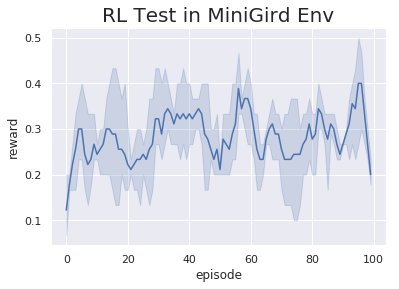


Evaluate RL agent on RandomMiniGrid Env
 99.67 *********

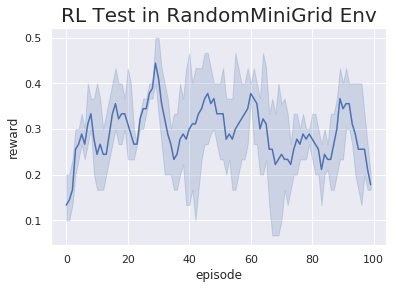

In [518]:
RL_EVALUATE_ITER_EVERY_TEST = 100
RL_EVALUATE_EPOCH_EVERY_ITER = 5

def smooth(data, sm=1):
    if sm > 1:
        y = np.ones(sm)*1.0/sm
        data = np.convolve(y, data, "same")
    return data

model = PPO.load("ppo_minigrid")
# model = PPO.load("ppo_sparseminigrid")

envs = {"MiniGird": MiniGridEnv, "RandomMiniGrid": RandomMiniGridEnv}

for k in envs.keys():
    print("\nEvaluate RL agent on {} Env".format(k))
    test_history = []
    for i in range(3):
        result = []
        env = envs[k]()
        for p in range(RL_EVALUATE_ITER_EVERY_TEST):
            finish = []
            print("\r","%.2f" % (100*i/3 + 100*p/RL_EVALUATE_ITER_EVERY_TEST/3), \
                  '*' * int(10*i/3 + 10*p/RL_EVALUATE_ITER_EVERY_TEST/3), end="",flush=True)
            for _ in range(RL_EVALUATE_EPOCH_EVERY_ITER):
                obs = env.reset()
                while True:
                    action, _states = model.predict(obs)
                    obs, reward, done, info = env.step(action)
                    if done:
                        if info.get("success") == True:
                            finish.append(1)
                        else:
                            finish.append(0)
                        break
            result.append(np.mean(finish))
        test_history.append(result)
    with open(pic_drawing_data_dir+"/"+k+".json", "w+") as f:
        json.dump(test_history, f)
    
#     with open(pic_drawing_data_dir+"/"+k+".json", "r+") as f:
#         test_history = json.load(f)

    i_data = []
    for line in test_history:
        line = smooth(line, 6)
        for index, result in enumerate(line):
            i_data.append([index, result])
    i_data = pd.DataFrame(i_data, columns=["episode", "reward"])
    sns.lineplot(x="episode", y="reward",data=i_data)
    plt.title("RL Test in {} Env".format(k), fontsize=20)
    plt.show()

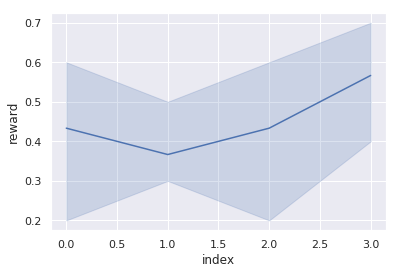

In [43]:
data = test_history
fig = plt.figure()
xdata = np.array([0, 1, 2, 3, 4, 5, 6])/5
linestyle = ['-', '--', ':', '-.']
color = ['r', 'g', 'b', 'k']
label = ['algo1', 'algo2', 'algo3', 'algo4']


i_data = []
for line in data:
    for index, result in enumerate(line):
        i_data.append([index, result])
i_data = pd.DataFrame(i_data, columns=["index", "reward"])

sns.lineplot(x="index", y="reward",data=i_data)

In [532]:
t = MiniGridEnv()
print(t.reset())

[[2 0 0 1 0 1]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]


     subject  timepoint event    region    signal
0        s13         18  stim  parietal -0.017552
1         s5         14  stim  parietal -0.080883
2        s12         18  stim  parietal -0.081033
3        s11         18  stim  parietal -0.046134
4        s10         18  stim  parietal -0.037970
...      ...        ...   ...       ...       ...
1059      s0          8   cue   frontal  0.018165
1060     s13          7   cue   frontal -0.029130
1061     s12          7   cue   frontal -0.004939
1062     s11          7   cue   frontal -0.025367
1063      s0          0   cue  parietal -0.006899

[1064 rows x 5 columns]


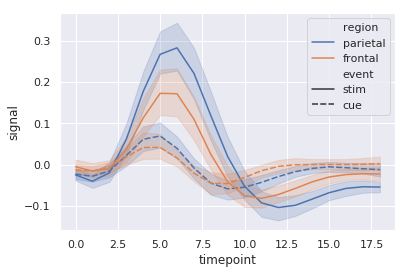

In [35]:
import seaborn as sns
sns.set(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")
print(fmri)

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

# IL evaluation
- IL trained with DFS and RL
- IL trained with same matrix / same parameters / random parameters / bayesian on random parameters


Evaluate IL agent Baysian on MiniGird Env
 99.67 *********
Evaluate IL agent FixMiniGrid on MiniGird Env
 99.67 *********
Evaluate IL agent MiniGrid on MiniGird Env
 99.67 *********
Evaluate IL agent RandomMiniGrid on MiniGird Env
 99.67 *********

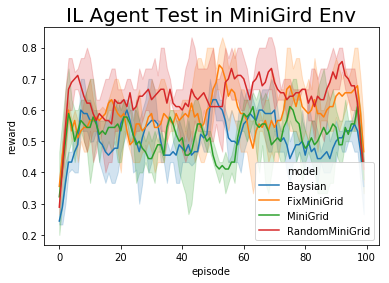


Evaluate IL agent Baysian on RandomMiniGrid Env
 99.67 *********
Evaluate IL agent FixMiniGrid on RandomMiniGrid Env
 99.67 *********
Evaluate IL agent MiniGrid on RandomMiniGrid Env
 99.67 *********
Evaluate IL agent RandomMiniGrid on RandomMiniGrid Env
 99.67 *********

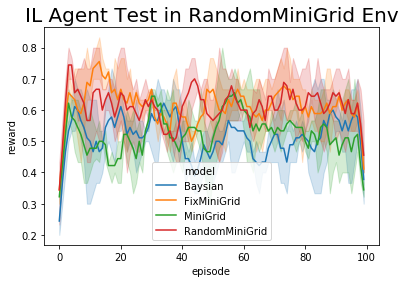

In [24]:
IL_EVALUATE_ITER_EVERY_TEST = 100
IL_EVALUATE_EPOCH_EVERY_ITER = 5

def smooth(data, sm=1):
    if sm > 1:
        y = np.ones(sm)*1.0/sm
        data = np.convolve(y, data, "same")
    return data

envs = {"MiniGird": MiniGridEnv(), "RandomMiniGrid": RandomMiniGridEnv()}
models = ["Baysian", "FixMiniGrid", "MiniGrid", "RandomMiniGrid"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k in envs.keys():
    env_history = []
    for m in models:
        model = ILAgent()
        model.net.load_state_dict(torch.load(IL_agent_dir+"/"+m+"_" +"ITER"+str(ITER_NUM)+".pkl"))
        model.net = model.net.to(device)
        model.net.eval()
        print("\nEvaluate IL agent {} on {} Env".format(m, k))
        test_history = []
        for i in range(3):
            result = []
            env = MiniGridEnv()
            for p in range(IL_EVALUATE_ITER_EVERY_TEST):
                print("\r","%.2f" % (100*i/3 + 100*p/IL_EVALUATE_ITER_EVERY_TEST/3), '*'*int(10*i/3 + 10*p/IL_EVALUATE_ITER_EVERY_TEST/3), end="",flush=True)
                finish = []
                for _ in range(IL_EVALUATE_EPOCH_EVERY_ITER):
                    obs = env.reset()
                    while True:
                        action= model.action(obs)
                        obs, reward, done, info = env.step(action)
                        if done:
                            if info.get("success") == True:
                                finish.append(1)
                            else:
                                finish.append(0)
                            break
                result.append(np.mean(finish))
            test_history.append(result)
#         with open(pic_drawing_data_dir+"/"+m+"_"+k+".json", "w+") as f:
#             json.dump(test_history, f)

    #     with open(pic_drawing_data_dir+"/"+m+"_"+k+".json", "r+") as f:
    #         test_history = json.load(f)

        i_data = []
        for line in test_history:
            line = smooth(line, 6)
            for index, result in enumerate(line):
                i_data.append([index, result, m])
        env_history.extend(i_data)
    env_history = pd.DataFrame(env_history, columns=["episode", "reward", "model"])
    sns.lineplot(x="episode", y="reward", hue="model", data=env_history)
    plt.title("IL Agent Test in {} Env".format(k), fontsize=20)
    plt.show()

# Bayesian Parameters tuning


Training IL agent Bayesian
 0.40 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 0.80 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 1.40 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 1.80 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 2.80 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 3.80 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 4.20 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 6.20 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 7.20 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 8.20 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 9.40 

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 10.20 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 10.40 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 11.80 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 12.20 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 13.00 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 13.40 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 14.40 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 14.80 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 15.20 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 16.00 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 16.20 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 16.80 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 18.00 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 18.60 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 19.00 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 19.80 *

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 21.00 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 21.40 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 21.80 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 22.00 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 23.20 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 24.00 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 24.20 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 25.00 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 25.60 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 26.00 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 26.40 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 27.00 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 27.20 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 27.60 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 29.60 **

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 31.00 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 31.60 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 32.80 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 33.80 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 34.40 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 34.60 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 35.00 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 35.20 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 37.40 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 38.20 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 38.60 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 39.20 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 39.40 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 39.80 ***

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 40.00 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 40.20 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 40.40 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 42.40 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 42.80 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 43.40 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 43.80 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 44.20 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 45.40 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 46.20 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 47.60 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 47.80 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 48.60 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 49.40 ****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 50.60 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 51.20 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 51.60 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 54.20 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 54.80 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 55.60 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 56.00 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 56.20 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 57.40 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 58.00 *****

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 60.00 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 61.00 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 62.00 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 62.80 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 63.00 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 63.80 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 64.00 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 64.20 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 64.40 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 64.80 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 65.00 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 67.40 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 68.80 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 69.80 ******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 70.80 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 71.00 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 71.20 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 72.00 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 72.40 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 72.60 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 74.40 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 75.20 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 75.60 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 75.80 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 77.20 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 77.60 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 79.60 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 79.80 *******

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 80.60 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 81.00 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 82.20 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 82.40 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 83.00 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 84.60 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 85.20 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 86.60 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 87.00 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 87.20 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 87.60 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 88.60 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 89.40 ********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 90.40 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 90.60 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 91.40 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 91.80 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 92.00 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 92.20 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 93.00 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 93.20 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 93.60 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 98.20 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 98.40 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 99.60 *********

/home/lemon/Environments/ugvr_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 99.80 *********
Evaluate IL agent RandomMiniGrid on MiniGird Env
 99.67 *********

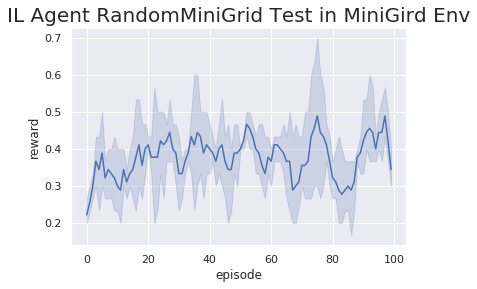


Evaluate IL agent RandomMiniGrid on RandomMiniGrid Env
 99.67 ***********

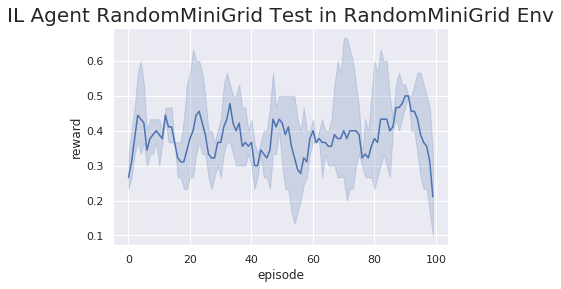

In [503]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing

class Bayesian():
    def __init__(self):
        self.X = []
        self.Y = []
        
        #poster sample number
        self.posterior_sample_number = 100
        
        self.position = 0
        #kernel
#         K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
        K = 1.0 * Matern()
        self.gp = GaussianProcessRegressor(kernel=K)
        
        self.capacity = 500
        
    def push(self, x, y):
        if len(self.X) < self.capacity:
            self.X.append(None)
            self.Y.append(None)
        self.X[self.position] = x
        self.Y[self.position] = y
        self.position = (self.position + 1) % self.capacity
    
    def _create_sample_x(self):
        samples = []
        for i in range(self.posterior_sample_number):
            s = np.random.rand(PARA_SIZE)
            samples.append(s)
        return samples
    
    def choose_next_sample(self):
        self.gp = self.gp.fit(self.X, self.Y)
        # 转置
        x_samples = self._create_sample_x()
        posterior_sample = self.gp.sample_y(x_samples, 1).T[0]
        which_max = np.argmax(posterior_sample)
        next_sample = x_samples[which_max]
        return next_sample

def evaluate_policy_on_env(agent, env):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_model = ILAgent()
    test_model.net = test_model.net.to(device)
    test_model.net.load_state_dict(agent.net.state_dict())
    test_model.net.eval()
    
    reward_history = []
#     for i in range(10):
#         obs = env.reset()
#         while True:
#             action = agent.action(obs)
#             sn_obs, reward, done, info = env.step(action)
#             if done:
#                 if info.get("success") == True:
#                     reward_history.append(1)
#                 else:
#                     reward_history.append(0)
#                 break
    for i in range(10):
            obs = env.reset()
            while True:
                action = agent.action(obs)
                sn_obs, reward, done, info = env.step(action)
                reward_history.append(reward)
                if done:
                    break
    return reward_history

print("\nTraining IL agent Bayesian")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize parameter
#     omega = torch.randn(PARA_SIZE)
omega = torch.zeros(PARA_SIZE)
# Acquire expert
dfs = DFS()
# Replay Buffer
buffer = ReplayMemory()
# Bayesian
bys = Bayesian()
agent = ILAgent()
agent.net = agent.net.to(device)
optimizer = torch.optim.SGD(agent.net.parameters(), lr=0.001, momentum=0.9)    

for j in range(ITER_NUM):
    print("\r","%.2f" % (100*j/ITER_NUM), '*'*int(10*j/ITER_NUM), end="",flush=True)

    env = MiniGridEnv(para=omega)

    # Get memory buffer
    expert_demo = get_expert_demo(env, RL=False, size=5*BATCH_SIZE)
    for h in expert_demo:
            buffer.push(torch.tensor(h[0]), torch.tensor([h[1]]))
    # Get parameters estimation
    for i in range(DEMO_EPISODE):
        test_env = MiniGridEnv(para=omega)
        mean_reward = evaluate_policy_on_env(agent,test_env)
        bys.push(omega.numpy().copy(), np.mean(mean_reward))    

    for _ in range(DEMO_EPISODE):
        expert_demo = get_expert_demo(env, RL=False)
        for h in expert_demo:
            buffer.push(torch.tensor(h[0]), torch.tensor([h[1]]))

    optimize_IL_agent(agent, buffer, optimizer)
    
    # OPTION
    # test_env = MiniGridEnv(para=torch.rand(PARA_SIZE))
    test_env = MiniGridEnv(para=omega)
    
    mean_reward = evaluate_policy_on_env(agent,test_env)
    bys.push(omega.numpy().copy(), np.mean(mean_reward))    
    omega = torch.tensor(bys.choose_next_sample()).float()


IL_EVALUATE_ITER_EVERY_TEST = 100
IL_EVALUATE_EPOCH_EVERY_ITER = 5

def smooth(data, sm=1):
    if sm > 1:
        y = np.ones(sm)*1.0/sm
        data = np.convolve(y, data, "same")
    return data

envs = {"MiniGird": MiniGridEnv(), "RandomMiniGrid": RandomMiniGridEnv()}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = agent
model.net.eval()

for k in envs.keys():
    print("\nEvaluate IL agent {} on {} Env".format(m, k))
    test_history = []
    for i in range(3):
        result = []
        env = MiniGridEnv()
        for p in range(IL_EVALUATE_ITER_EVERY_TEST):
            print("\r","%.2f" % (100*i/3 + 100*p/IL_EVALUATE_ITER_EVERY_TEST/3), '*'*int(10*i/3 + 10*p/IL_EVALUATE_ITER_EVERY_TEST/3), end="",flush=True)
            finish = []
            for _ in range(IL_EVALUATE_EPOCH_EVERY_ITER):
                obs = env.reset()
                while True:
                    action= model.action(obs)
                    obs, reward, done, info = env.step(action)
                    if done:
                        if info.get("success") == True:
                            finish.append(1)
                        else:
                            finish.append(0)
                        break
            result.append(np.mean(finish))
        test_history.append(result)

    i_data = []
    for line in test_history:
        line = smooth(line, 6)
        for index, result in enumerate(line):
            i_data.append([index, result])
    i_data = pd.DataFrame(i_data, columns=["episode", "reward"])
    sns.lineplot(x="episode", y="reward",data=i_data)
    plt.title("IL Agent {} Test in {} Env".format(m, k), fontsize=20)
    plt.show()

0